In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.special import comb
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, f1_score

In [25]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

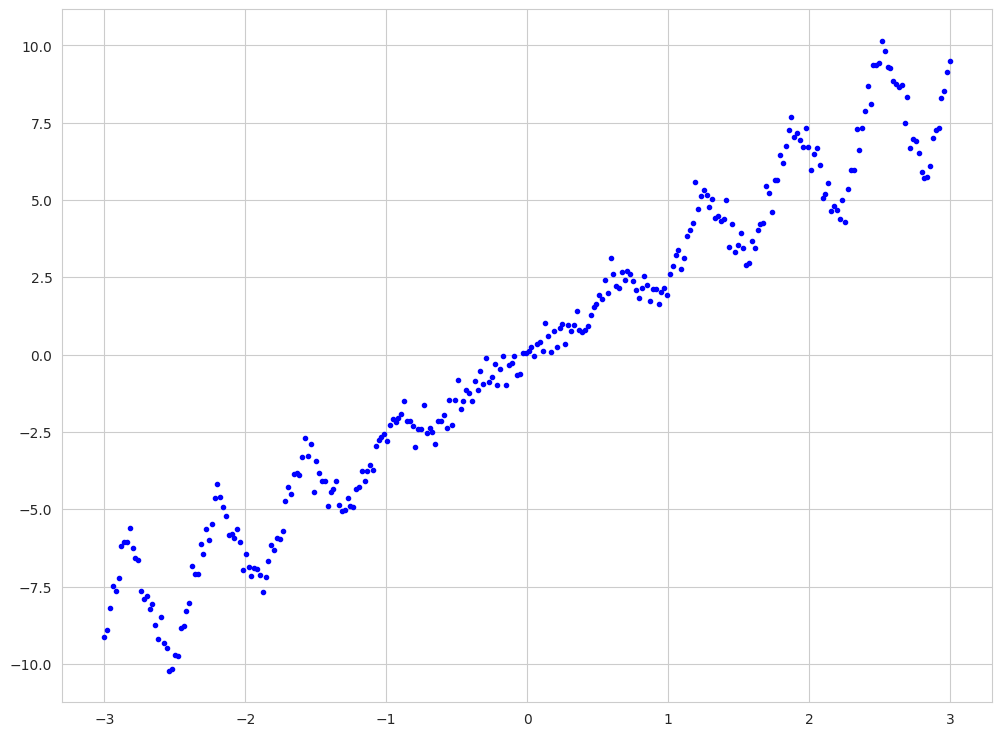

In [14]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [15]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

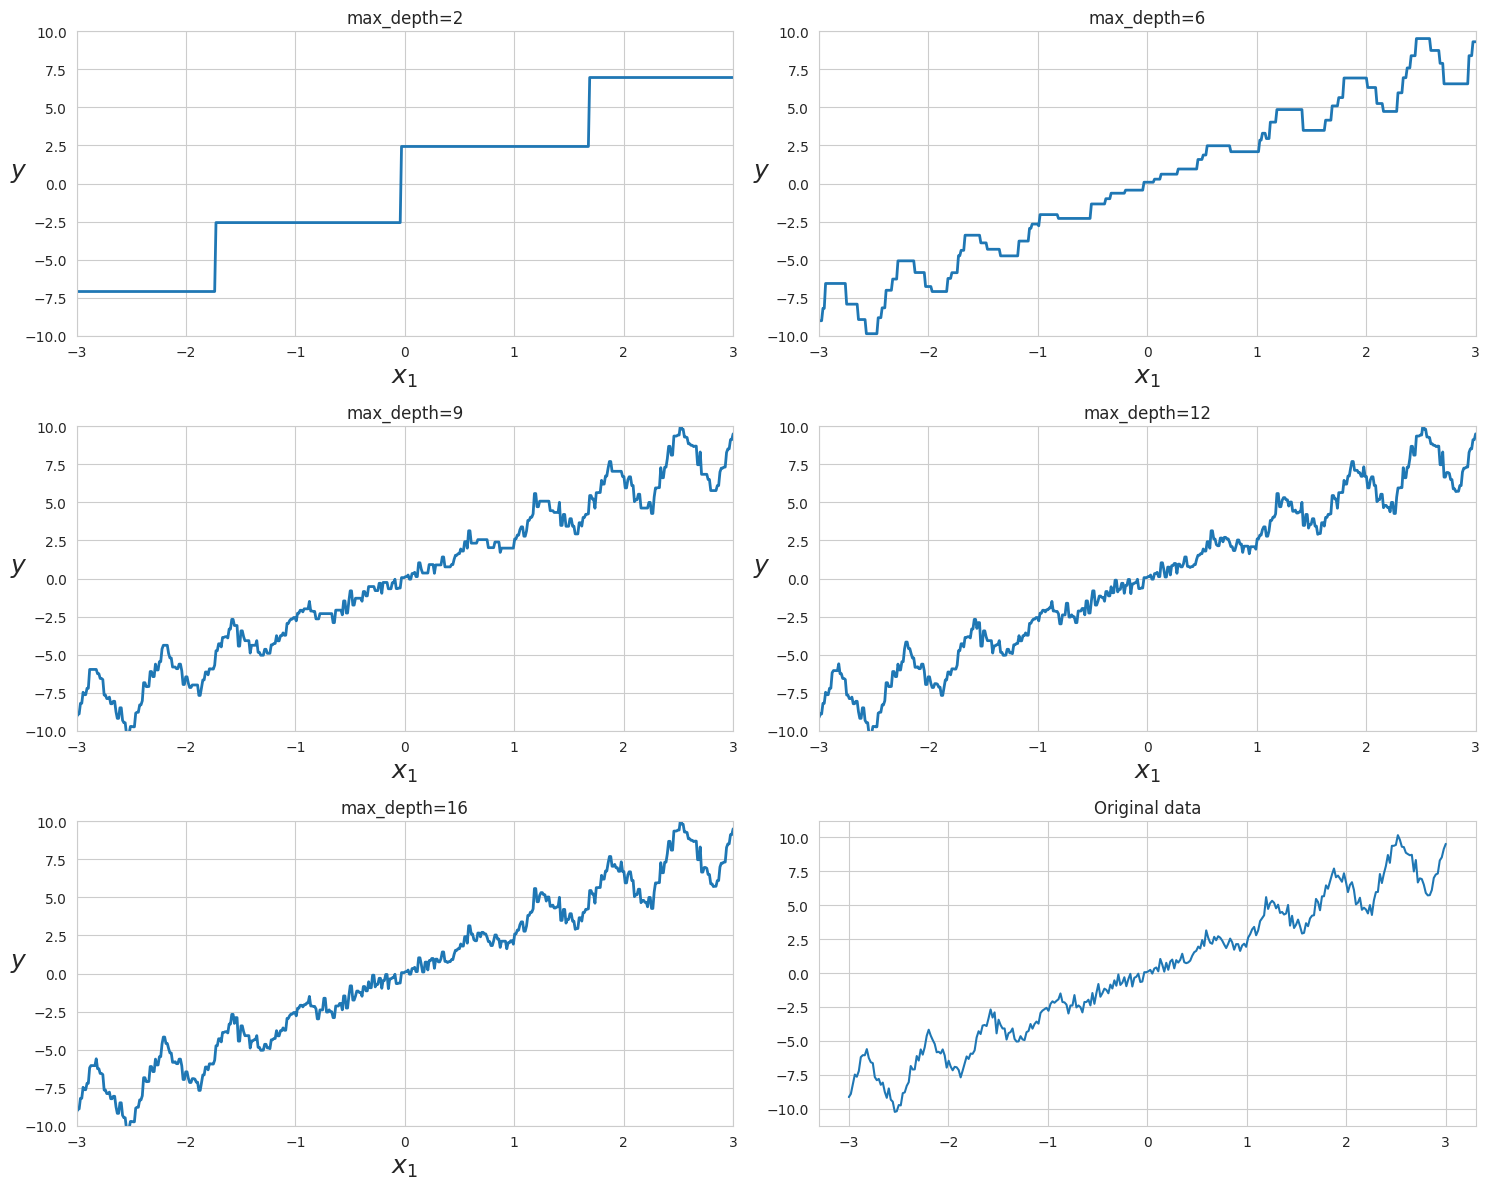

In [16]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=SEED)
tree_reg2 = DecisionTreeRegressor(max_depth=6, random_state=SEED)
tree_reg3 = DecisionTreeRegressor(max_depth=9, random_state=SEED)
tree_reg4 = DecisionTreeRegressor(max_depth=12, random_state=SEED)
tree_reg5 = DecisionTreeRegressor(max_depth=16, random_state=SEED)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)
tree_reg3.fit(X, y)
tree_reg4.fit(X, y)
tree_reg5.fit(X, y)

plt.figure(figsize=(15, 12))

plt.subplot(321)
plot_regression_predictions(tree_reg1, X, y, ylabel="$y$")
plt.title("max_depth=2")

plt.subplot(322)
plot_regression_predictions(tree_reg2, X, y, ylabel="$y$")
plt.title("max_depth=6")

plt.subplot(323)
plot_regression_predictions(tree_reg3, X, y, ylabel="$y$")
plt.title("max_depth=9")

plt.subplot(324)
plot_regression_predictions(tree_reg4, X, y, ylabel="$y$")
plt.title("max_depth=12")

plt.subplot(325)
plot_regression_predictions(tree_reg5, X, y, ylabel="$y$")
plt.title("max_depth=16")

plt.subplot(326)
plt.plot(X, y)
plt.title("Original data")

plt.tight_layout()
plt.show()

Видно, что на моделях с малой глубиной у нас идет сильное упрощение предсказаний(высокий bias), которые не отражают реальных данных. При увеличении глубины модель начинает лучше предсказывать тренировочные данные(сравнение с original data). Однако, мы не знаем, насколько большой variance у нашей модели(насколько она переобучена), так как для этого нужно сравнение с тестовыми данными. Давайте попробуем разделить выборку и оценить variance с помощью r2 score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=SEED)
tree_reg2 = DecisionTreeRegressor(max_depth=6, random_state=SEED)
tree_reg3 = DecisionTreeRegressor(max_depth=9, random_state=SEED)
tree_reg4 = DecisionTreeRegressor(max_depth=12, random_state=SEED)
tree_reg5 = DecisionTreeRegressor(max_depth=16, random_state=SEED)
tree_reg1.fit(X_train, y_train)
tree_reg2.fit(X_train, y_train)
tree_reg3.fit(X_train, y_train)
tree_reg4.fit(X_train, y_train)
tree_reg5.fit(X_train, y_train)
y_pred1 = tree_reg1.predict(X_test)
y_pred2 = tree_reg2.predict(X_test)
y_pred3 = tree_reg3.predict(X_test)
y_pred4 = tree_reg4.predict(X_test)
y_pred5 = tree_reg5.predict(X_test)
print(f'R2 score of max_depth = 2 model:', r2_score(y_test, y_pred1))
print(f'R2 score of max_depth = 6 model:', r2_score(y_test, y_pred2))
print(f'R2 score of max_depth = 9 model:', r2_score(y_test, y_pred3))
print(f'R2 score of max_depth = 12 model:', r2_score(y_test, y_pred4))
print(f'R2 score of max_depth = 16 model:', r2_score(y_test, y_pred5))



R2 score of max_depth = 2 model: 0.8963960271203124
R2 score of max_depth = 6 model: 0.9860742925187541
R2 score of max_depth = 9 model: 0.9914777283350705
R2 score of max_depth = 12 model: 0.9919977920574086
R2 score of max_depth = 16 model: 0.9919922651330997


Видно, что у модели с максимальной глубиной в 16 r2 ниже, чем у модели 12. Значит, variance действительно после определенной глубины начинает повышаться.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ i p ^ i (1-p) ^ {101-i} $$

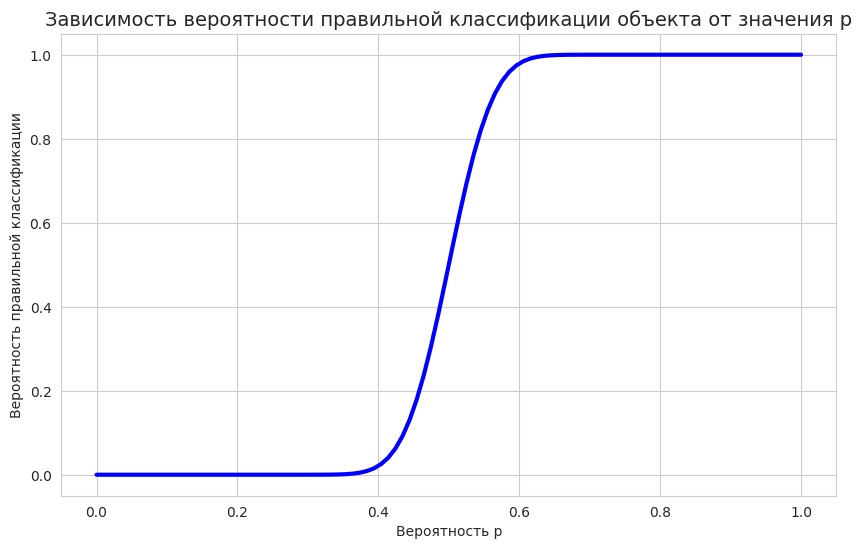

In [31]:
def majority_vote_probability(p):
    total_probability = 0
    for i in range(51, 102):
        total_probability += comb(101, i) * (p**i) * ((1-p)**(101-i))
    return total_probability

p_values = np.linspace(0, 1, 100)
accuracies = [majority_vote_probability(p) for p in p_values]

plt.figure(figsize=(10, 6))
plt.plot(p_values, accuracies, color='blue', linewidth=3)
plt.xlabel('Вероятность p', fontsize=10)
plt.ylabel('Вероятность правильной классификации', fontsize=10)
plt.title('Зависимость вероятности правильной классификации объекта от значения p', fontsize=14)
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

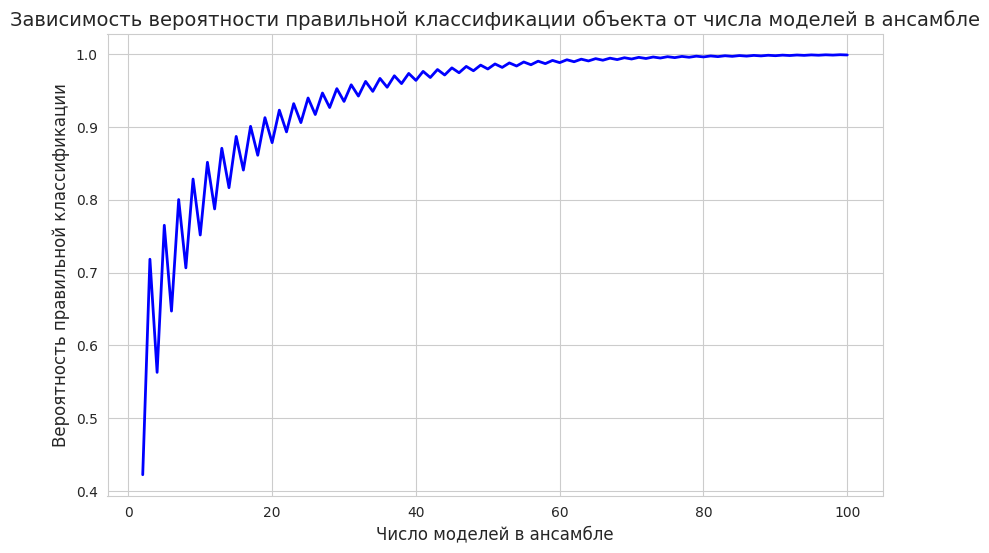

In [42]:
def majority_vote_probability_alternative(nmodels, p):
    total_probability = 0
    for i in range(nmodels // 2 + 1, nmodels + 1):
        total_probability += comb(nmodels, i) * (p**i) * ((1 - p)**(nmodels - i))
    return total_probability

p = 0.65
num_models_values = np.arange(2, 101)
accuracies = [majority_vote_probability_alternative(num_models, p) for num_models in num_models_values]

plt.figure(figsize=(10, 6))
plt.plot(num_models_values, accuracies, color='blue', linewidth=2)
plt.xlabel('Число моделей в ансамбле', fontsize=12)
plt.ylabel('Вероятность правильной классификации', fontsize=12)
plt.title('Зависимость вероятности правильной классификации объекта от числа моделей в ансамбле', fontsize=14)
plt.grid(True)
plt.show()


Опишите ваши наблюдения.
Вероятности правильной классификации в зависимости от:

* Значения вероятности правильного предсказания моделей при их фиксированном количества.
График - сигмоида, с резким изгибом в районе p = 0.5. Причем при достижении ~0.6 график начинает выходить на плато с точностью предсказаний ансамбля в районе 1(при p отдельной модели в 0.6! удивительно!!). Получается, для ансамбля достаточно небольшого отклонения вероятности моделей в сторону > 0.5 для практически одноозначной классификации(верной).

* Количества моделей при фиксированном p видим график "насыщения", где увеличение количества моделей дает сначала резки, потом плавный рост к вероятности правильной классификации, рост в итоге выходит на плато в районе 80 моделей, где вероятность правильной классификации ~1. Нужно понимать, что рост будет тем стремительнее, чем выше у нас p отдельной модели(и при условии p>=0.5, так как значения выше будут давать график уменьшения вероятности - считай, отраженный по вертикали)

Выводы: 
1. Даже при небольших успехах отдельной модели можно добиться уверенной классификации в случае их ансамблей
2. Чем больше моделей, тем лучше) Однако, чтобы сохранить вычислительные ресурсы, заранее оценить достаточное количество моделей для нужных результатов. А если результаты нас устраивают - посмотреть, можно ли уменьшить количество моделей без существенной потери качества.


#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [168]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, min_samples_leaf=1, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.min_samples_leaf = min_samples_leaf

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            
            sample_indices = np.random.randint(0, n_samples, size=n_samples)
            X_sampled = X[sample_indices][:, feat_ids].reshape(X.shape[0], -1)
            y_sampled = y[sample_indices]
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_sampled, y_sampled)
            
            self.trees.append(tree)
            
        return self
    
    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            probas += tree.predict_proba(X[:, feat_ids])

        return probas / len(self.trees)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        prediction = np.argmax(proba, axis=1)
        
        return prediction

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [156]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

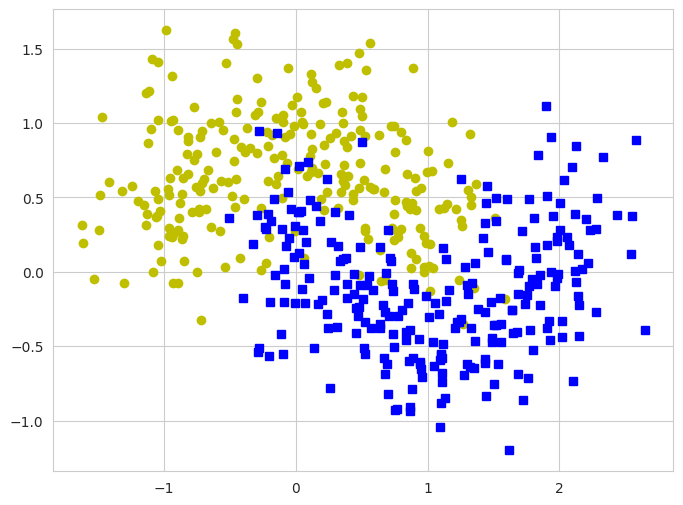

In [157]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

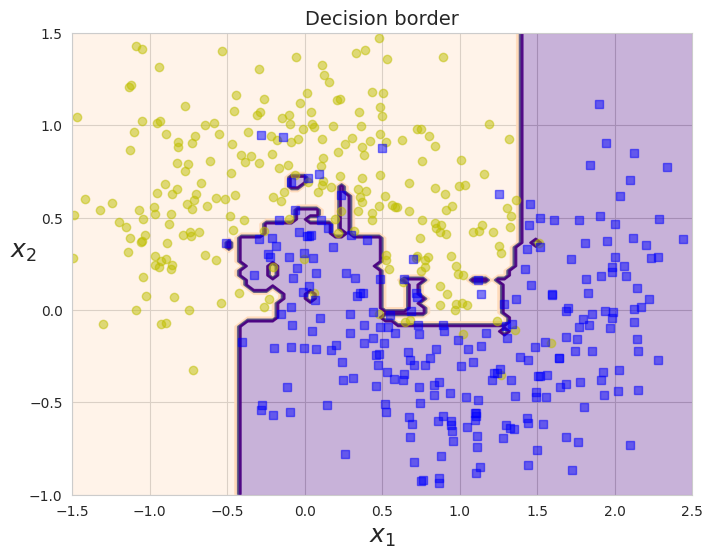

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(max_depth=20, max_features=2)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Предсказание тренировочных данных практически идеальное, однако явно видно переобучение и высокий variance.

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [176]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 8, 14, 20],
    'max_features': [1, 2],
    'min_samples_leaf': [1, 2, 4]
}

clf = RandomForestClassifierCustom()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 200}


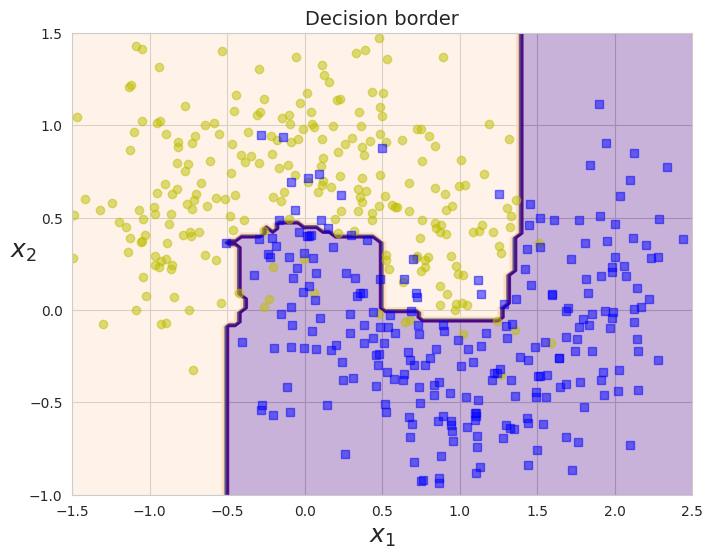

In [177]:
plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(max_depth=5, max_features=2, min_samples_leaf=1, n_estimators=200)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Вот это вот богоугодненько! хороший bias-variance баланс, я считаю

In [178]:

# Оценка производительности лучшей модели на тестовых данных
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = f1_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the best model:", accuracy)

Accuracy of the best model: 0.9166666666666666


f1 score тоже неплохо себя показал.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [235]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X_test):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        ypred_t1 = est1.predict_proba(X_test)[:, 1]
        ypred_t2 = est2.predict_proba(X_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [236]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [237]:
model1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
model1.fit(X_train, y_train)

correlations = base_model_pair_correlation(model1, X_test)

In [238]:
print(f'{min(correlations) = }',
      f'{max(correlations) = }',
       f'{np.mean(correlations) = }', sep='\n')

min(correlations) = 0.610628568994068
max(correlations) = 0.9573043795157633
np.mean(correlations) = 0.7856250038674629


Высокая корреляция между параметрами(

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [239]:
max_depth_values = [5, 10, 15, 20]
correlations_per_max_depth = {}

for max_depth in max_depth_values:
    model = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=SEED)
    model.fit(X_train, y_train)
    
    correlations = base_model_pair_correlation(model, X_test)
    correlations_per_max_depth[max_depth] = correlations

for max_depth, correlations in correlations_per_max_depth.items():
    print(f"Max Depth: {max_depth}")
    print(f"Mean Correlation: {np.mean(correlations)}")
    print(f"Std Correlation: {np.std(correlations)}")

Max Depth: 5
Mean Correlation: 0.8134916193685199
Std Correlation: 0.04773888497232329
Max Depth: 10
Mean Correlation: 0.7856250038674629
Std Correlation: 0.052293532701241305
Max Depth: 15
Mean Correlation: 0.7851451352261626
Std Correlation: 0.05263466856007994
Max Depth: 20
Mean Correlation: 0.7851451352261626
Std Correlation: 0.05263466856007994


Опишите ваши наблюдения:

* Видно, что с повышением глубины у нас понижается корреляция. Это неудивительно: чем больше глубина дерева, тем большее количество формаций оно может иметь -> меньше шанс совпадения двух разных деревьев в ансамбле

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [10]:
heart_dataset = pd.read_csv("../data/heart.csv")

In [11]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [12]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
model_scoring = {}
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    if model == voting_hard: # Это необходимо, потому что у voting_hard и soft одинаковые названия классов
        model_scoring['voting_hard'] = scores.mean()
    elif model == voting_soft:
        model_scoring['voting_soft'] = scores.mean()
    else:
        model_scoring[model.__class__.__name__] = scores.mean()

[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [14]:
for key, value in model_scoring.items():
    print(key, 'mean score:', value)

DecisionTreeClassifier mean score: 0.797997226792219
RandomForestClassifier mean score: 0.8328751280279528
CatBoostClassifier mean score: 0.8342715174922052
ExtraTreesClassifier mean score: 0.8281746031746032
KNeighborsClassifier mean score: 0.6493313763861709
SVC mean score: 0.6973119072190279
XGBClassifier mean score: 0.8134522115571786
LGBMClassifier mean score: 0.8132478632478634
XGBRFClassifier mean score: 0.8499478840942256
LogisticRegression mean score: 0.8500073681108163
GaussianNB mean score: 0.8140676625250128
voting_hard mean score: 0.8494440278941667
voting_soft mean score: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [15]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [16]:
def remove_highly_correlated_models(voting_clf, X_test, threshold=0.8):
    corrected_models = voting_clf.estimators_
    blank = VotingClassifier(estimators=voting_clf.estimators, voting=voting_clf.voting) # чтобы не менять .estimators_ у исходного ансамбля
    blank.estimators_ = voting_clf.estimators_
    correlations = base_model_pair_correlation_for_voting_clf(blank, X_test)
    
    max_corr_value = 0
    
    for i, (est1, est2, corr) in enumerate(correlations):
        if corr > max_corr_value:
            model_to_delete = est1
            max_corr_value = corr
    
    while max_corr_value > threshold:
        # Удаляем модель с наибольшей корреляцией из ансамбля
        corrected_models = [est for est in corrected_models if est != model_to_delete]
        # Обновляем список корреляций после удаления модели
        blank.estimators_ = corrected_models
        correlations = base_model_pair_correlation_for_voting_clf(blank, X_test)
        
        # Находим новую модель с наибольшей корреляцией
        max_corr_value = 0
        for i, (est1, est2, corr) in enumerate(correlations):
            if corr > max_corr_value:
                model_to_delete = est1
                max_corr_value = corr
    
    estimators = []
    for model in corrected_models:
        estimators.append((model.__class__.__name__, model))
    return estimators # решил вместо того, чтобы возвращать VotingClassifier, возвращать estimators list, чтобы затем его можно было отредактировать и создать ансамбль

In [17]:
voting_hard.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('ETC', ExtraTreesClassifier(random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SV...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              random_state=111, reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('NB', GaussianNB())])

In [26]:
corrected_estimators = remove_highly_correlated_models(voting_hard, X_test, threshold=0.90)
corrected_voting_hard = VotingClassifier(estimators=corrected_estimators, voting='hard')
corrected_voting_hard.fit(X_train, y_train) # новый ансамбль
print('Оценка кросс валидации для нового ансамбля:', cross_val_score(corrected_voting_hard, X_train, y_train, cv=3, scoring="f1").mean())

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

Оценка стала повыше, но не намного. Давайте попробуем что нибудь убрать/добавить, для получения лучших результатов (другие threshold проверял, они хуже)

In [27]:
corrected_estimators.append(('RF', RandomForestClassifier(n_estimators=300, random_state=111, min_samples_split=20, min_samples_leaf=10))) # решил добавить random forest с новыми настройками(вроде не было запрещено)

In [28]:
del corrected_estimators[-2] # магия перебора
del corrected_estimators[2]

In [29]:
corrected_voting_hard = VotingClassifier(estimators=corrected_estimators, voting='hard')
corrected_voting_hard.fit(X_train, y_train) # новый ансамбль

VotingClassifier(estimators=[('DecisionTreeClassifier',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('KNeighborsClassifier',
                              KNeighborsClassifier(weights='distance')),
                             ('XGBRFClassifier',
                              XGBRFClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rou...
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              random_state=111, reg_alpha=None, ...)),
                             ('LogisticRegression',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('RF',
                              RandomForestClassifier(min_samples_leaf=10,
                                                     min_samples_split=20,
                                                     n_estimators=300,
                                                     random_state=111))])

In [30]:
print('Оценка кросс валидации для нового ансамбля:', cross_val_score(corrected_voting_hard, X_train, y_train, cv=3, scoring="f1").mean())

Оценка кросс валидации для нового ансамбля: 0.8703727245760916


Больше 0.87!

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [3]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


array([[<Axes: title={'center': 'Account Length'}>,
        <Axes: title={'center': 'Area Code'}>,
        <Axes: title={'center': 'VMail Message'}>,
        <Axes: title={'center': 'Day Mins'}>],
       [<Axes: title={'center': 'Day Calls'}>,
        <Axes: title={'center': 'Day Charge'}>,
        <Axes: title={'center': 'Eve Mins'}>,
        <Axes: title={'center': 'Eve Calls'}>],
       [<Axes: title={'center': 'Eve Charge'}>,
        <Axes: title={'center': 'Night Mins'}>,
        <Axes: title={'center': 'Night Calls'}>,
        <Axes: title={'center': 'Night Charge'}>],
       [<Axes: title={'center': 'Intl Mins'}>,
        <Axes: title={'center': 'Intl Calls'}>,
        <Axes: title={'center': 'Intl Charge'}>,
        <Axes: title={'center': 'CustServ Calls'}>]], dtype=object)

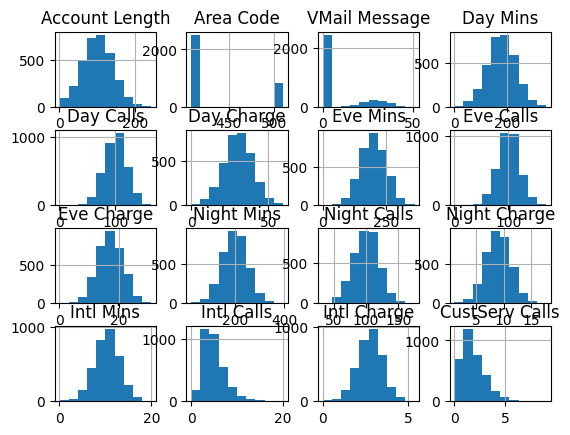

In [4]:
data.hist()

Неплохо было бы стандартизовать данные

Давайте перекодируем планы и churn, а так же определим категориальные признаки

In [5]:
data.nunique()

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

In [6]:
data['Churn?'] = (data['Churn?'] == 'True.')
data['VMail Plan'] = (data['VMail Plan'] == 'yes')
data['Int\'l Plan'] = (data['Int\'l Plan'] == 'yes')

In [7]:
data['Area Code'] = data['Area Code'].astype('category')
data['State'] = data['State'].astype('category')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   State           3333 non-null   category
 1   Account Length  3333 non-null   int64   
 2   Area Code       3333 non-null   category
 3   Phone           3333 non-null   object  
 4   Int'l Plan      3333 non-null   bool    
 5   VMail Plan      3333 non-null   bool    
 6   VMail Message   3333 non-null   int64   
 7   Day Mins        3333 non-null   float64 
 8   Day Calls       3333 non-null   int64   
 9   Day Charge      3333 non-null   float64 
 10  Eve Mins        3333 non-null   float64 
 11  Eve Calls       3333 non-null   int64   
 12  Eve Charge      3333 non-null   float64 
 13  Night Mins      3333 non-null   float64 
 14  Night Calls     3333 non-null   int64   
 15  Night Charge    3333 non-null   float64 
 16  Intl Mins       3333 non-null   float64 
 17  Intl Calls    

In [9]:
data = data.rename(columns={'Churn?': 'churn'})

In [10]:
catcols = ['Area Code', 'State', 'VMail Plan', "Int'l Plan"]
numcols = data.drop(columns=catcols).drop(columns=['Phone', 'churn']).columns
# catcols = [data.columns.get_loc(c) for c in catcols if c in data]
# numcols = [data.columns.get_loc(c) for c in numcols if c in data]

Готово!

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='churn'), 
                                                    data['churn'], 
                                                    test_size=0.2,
                                                    random_state=SEED)

In [30]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numcols),
    ("ohe", OneHotEncoder(drop="first"), catcols)
])

params_rf = {
    'boosting_type': 'rf',
    'num_leaves': 35,
    'max_depth': 6,  # -1 means no limit
    'learning_rate': 0.1,
    'n_estimators': 300,
    'random_state': SEED,
    'feature_fraction': 0.85
}
knn_pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", lightgbm.LGBMClassifier(**params_rf))
])

params_gbdt = {
    'boosting_type': 'gbdt',
    'num_leaves': 35,
    'max_depth': 6,  # -1 means no limit
    'learning_rate': 0.2,
    'n_estimators': 300,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'random_state': SEED,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.85,
    'bagging_freq': 2
}
knn_pipeline_boost = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", lightgbm.LGBMClassifier(**params_gbdt))
])

knn_pipeline_rf.fit(X_train, y_train)
knn_pipeline_boost.fit(X_train, y_train)

y_pred_rf = knn_pipeline_rf.predict(X_test)
y_pred_boost = knn_pipeline_boost.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Info] Number of positive: 389, number of negative: 2277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145911 -> initscore=-1.767035
[LightGBM] [Info] Start training from score -1.767035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Перебрал большое количество параметров, но эти выдают f1_score больше, чем у остальных

In [34]:
print('accuracy_score for lightgbm randomforest:', accuracy_score(y_test, y_pred_rf))
print('accuracy_score for lightgbm gbdt:', accuracy_score(y_test, y_pred_boost))
print('f1_score for lightgbm randomforest:', f1_score(y_test, y_pred_rf))
print('f1_score for lightgbm gbdt:', f1_score(y_test, y_pred_boost))

accuracy_score for lightgbm randomforest: 0.9205397301349325
accuracy_score for lightgbm gbdt: 0.9610194902548725
f1_score for lightgbm randomforest: 0.7103825136612022
f1_score for lightgbm gbdt: 0.8452380952380952


Видно, что по accuracy обе модели отлично справляются, однако если брать f1 score - буст на голову выше!

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

![drawing_ensemble](../data/drawing.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

богоугодное задание👍